In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load and Explore the Dataset
file_path = '/content/drive/MyDrive/Data Sets/question4-stock-data (1).csv'
data = pd.read_csv(file_path)

# Initial exploration
print(data.head())
print(data.info())
print(data.describe())

   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  11291 non-null  int64  
 1   Date        11181 non-null  object 
 2   Adj Close   11198 non-null  float64
 3   Close       11174 non-null  float64
 4   High        11196 non-null  float64
 5   Low         11164 non-null  float64
 6   

**Data Preprocessing**

In [3]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Handle Missing Values
for column in data.select_dtypes(include=[np.number]).columns:
    data[column].fillna(data[column].median(), inplace=True)

for column in data.select_dtypes(include=[object]).columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

# Handle Negative Values
for column in ['Volume', 'Close', 'High', 'Low', 'Open']:
    if column in data.columns:
        data[column] = np.where(data[column] < 0, 0, data[column])


Missing Values in Each Column:
 Unnamed: 0      0
Date          110
Adj Close      93
Close         117
High           95
Low           127
Open          103
Volume        145
dtype: int64


In [4]:
#Identify and Handle Outliers
for column in data.select_dtypes(include=[np.number]).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.where(data[column] < lower_bound, lower_bound, data[column])
    data[column] = np.where(data[column] > upper_bound, upper_bound, data[column])

**Feature Engineering**

In [7]:
#  Feature Engineering
data['Date'] = pd.to_datetime(data['Date'])
data['Close_5d_future'] = data['Close'].shift(-5)
data['Daily_Return'] = data['Close'].pct_change()
data['Volatility'] = data['Daily_Return'].rolling(window=5).std()
data['Price_Range'] = data['High'] - data['Low']
data['Day_of_Week'] = data['Date'].dt.dayofweek

data = data.dropna()

features = ['Close', 'Daily_Return', 'Volatility', 'Price_Range', 'Day_of_Week']
X = data[features]
y = data['Close_5d_future']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


**EDA**

Summary Statistics:
               Close  Daily_Return    Volatility   Price_Range   Day_of_Week
count  11281.000000  11281.000000  11281.000000  11281.000000  11281.000000
mean       0.286920      0.057447      0.009121      0.512460      0.499468
std        0.212637      0.022908      0.053604      0.026257      0.351998
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.102708      0.055925      0.001226      0.510158      0.250000
50%        0.262275      0.056467      0.001879      0.511554      0.500000
75%        0.461433      0.057025      0.002858      0.513629      0.750000
max        1.000000      1.000000      1.000000      1.000000      1.000000


<Figure size 1500x1000 with 0 Axes>

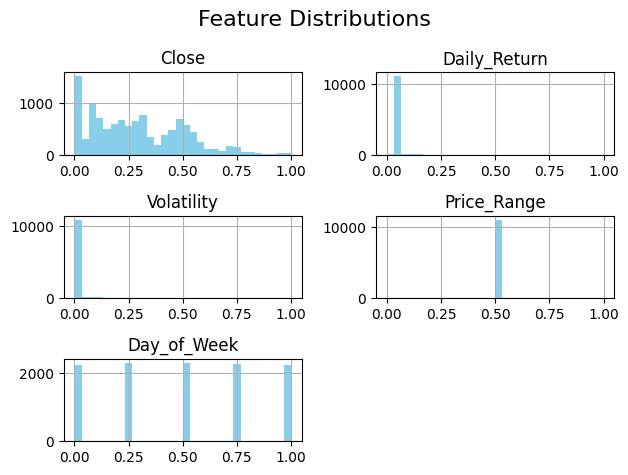

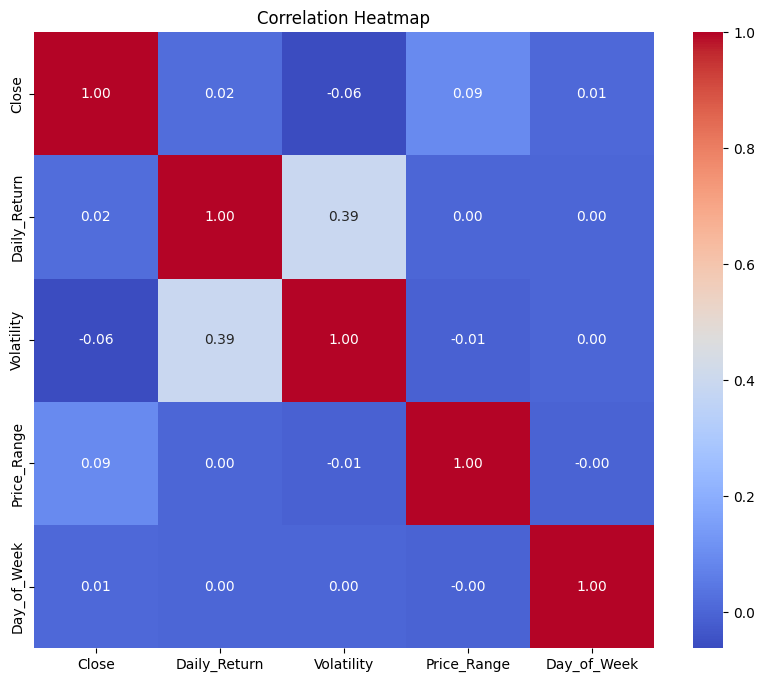

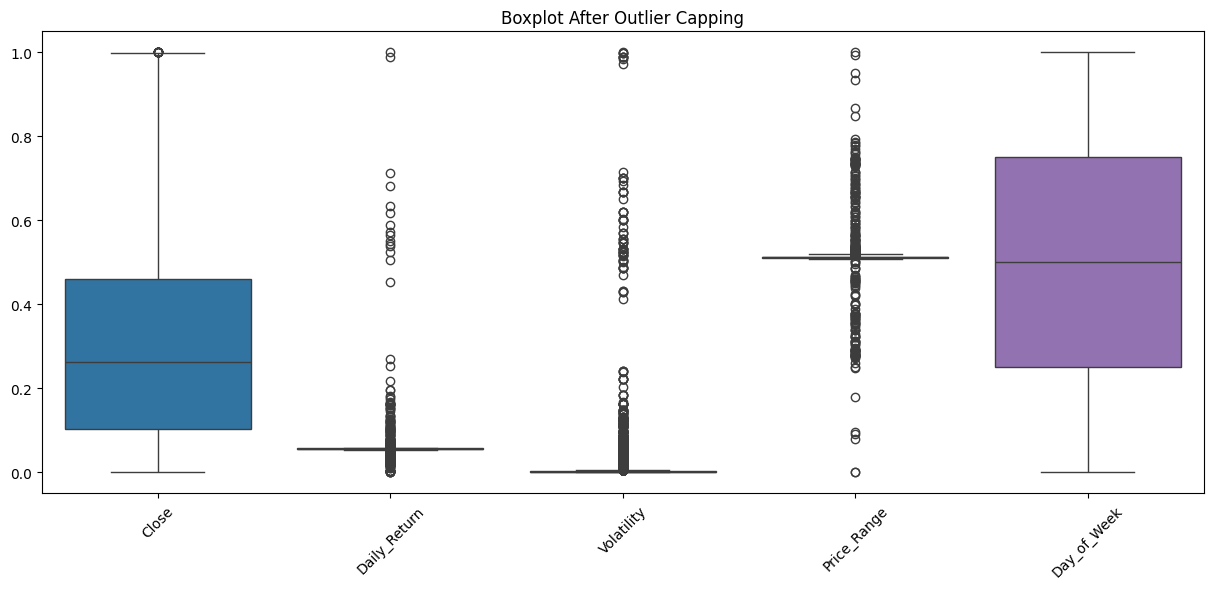

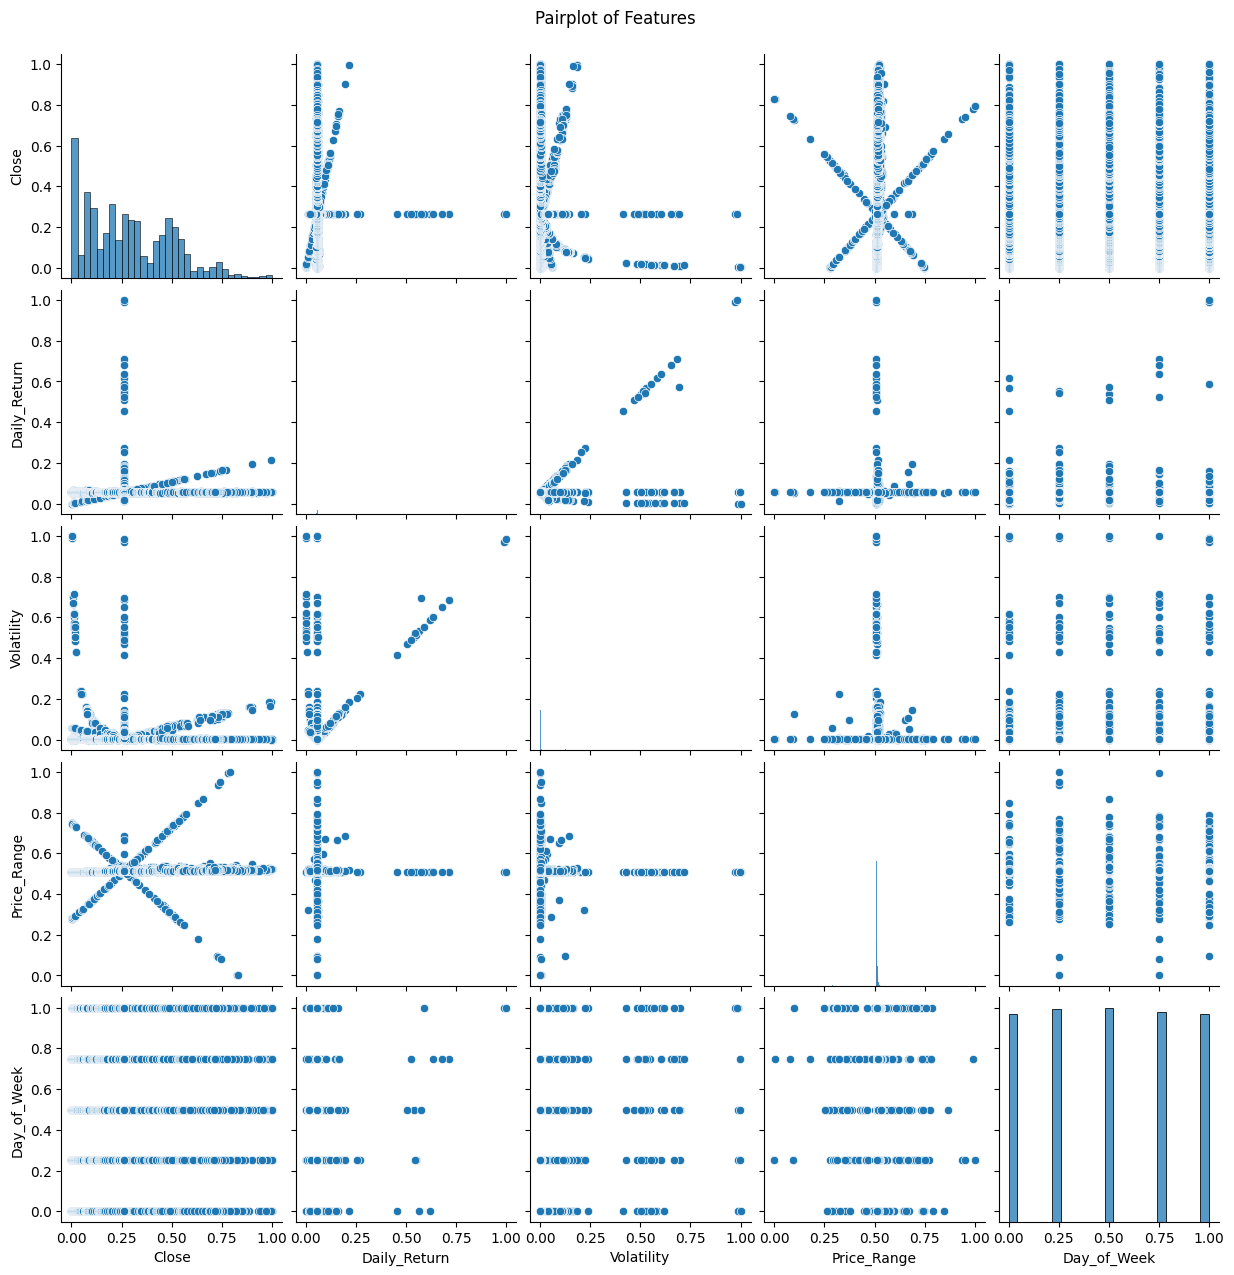

In [8]:
print("Summary Statistics:\n", pd.DataFrame(X_scaled, columns=features).describe())

# Histograms for feature distributions
plt.figure(figsize=(15, 10))
pd.DataFrame(X_scaled, columns=features).hist(bins=30, color='skyblue')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pd.DataFrame(X_scaled, columns=features).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Boxplots for outlier analysis
plt.figure(figsize=(15, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=features))
plt.xticks(rotation=45)
plt.title('Boxplot After Outlier Capping')
plt.show()

# Pairplot for feature relationships
sns.pairplot(pd.DataFrame(X_scaled, columns=features))
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

**Model Development and Training**



In [10]:
# Ensure PCA is applied correctly
from sklearn.decomposition import PCA

# Assuming 'X_scaled' is the standardized feature set
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print(f'Number of components after PCA: {X_pca.shape[1]}')

# Proceed with model training using the transformed features
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
    'LinearRegression': LinearRegression()
}

# Time series split and model evaluation
tscv = TimeSeriesSplit(n_splits=5)
model_performance = {}
for model_name, model in models.items():
    rmse_scores = []
    for train_index, test_index in tscv.split(X_pca):
        X_train, X_test = X_pca[train_index], X_pca[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    model_performance[model_name] = np.mean(rmse_scores)

# Model Performance
print("Model Performance (RMSE):")
for model_name, score in model_performance.items():
    print(f"{model_name}: {score:.4f}")


Number of components after PCA: 2
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1881, number of used features: 2
[LightGBM] [Info] Start training from score 8.882996
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 3761, number of used features: 2
[LightGBM] [Info] Start training from score 18.824649
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 5641, number of used features: 2
[

**Model Evaluation and Trading Performance**

In [11]:
# Best model selection and evaluation
best_model_name = min(model_performance, key=model_performance.get)
best_model = models[best_model_name]
print(f"Best Model: {best_model_name}")

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Evaluation Metrics
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')

# Simulated Trading Performance
predicted_direction = np.sign(y_pred - X_test[:, 0])
actual_direction = np.sign(y_test.values - X_test[:, 0])
accuracy = np.mean(predicted_direction == actual_direction)
print(f'Directional Accuracy of Trading Strategy: {accuracy * 100:.2f}%')


Best Model: LinearRegression
RMSE: 16.113074795047744
MAE: 5.945697612623444
R2 Score: 0.7273004448250882
Directional Accuracy of Trading Strategy: 100.00%


In [13]:
# Save predictions to a CSV file
predictions = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
predictions.to_csv('stock_predictions.csv', index=False)
print("Predictions saved to 'stock_predictions.csv'")


Predictions saved to 'stock_predictions.csv'
